Digits Recognition
=============

We use Tensor Flow on MNIST data. Thanks to <a href="https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/udacity">Google's Udacity course</a> for demonstrating how to use neural networks in Tensor Flow.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import clock

# Force matplotlib to not use any Xwindows backend.
# import matplotlib
# matplotlib.use('Agg')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read training data
start = clock()

train_frame = pd.read_csv('data/train.csv')

# Make random train and validation sets
from sklearn.cross_validation import train_test_split
train_frame, valid_frame = train_test_split(train_frame, test_size = 0.2)

train_labels = train_frame['label'].values
train_dataset = train_frame.iloc[:,1:].values

valid_labels = valid_frame['label'].values
valid_dataset = valid_frame.iloc[:,1:].values

print('Loaded {:d} train entries in {:.0f} seconds.'.format(
        len(train_dataset) + len(valid_dataset), clock() - start))

# Read test data 
start = clock()

test_frame = pd.read_csv('data/test.csv')
test_dataset = test_frame.values

print('Loaded {:d} test entries in {:.0f} seconds.'.format(
        len(test_dataset), clock() - start))

Loaded 42000 train entries in 4 seconds.
Loaded 28000 test entries in 2 seconds.


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset, labels = None):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  if labels is not None:
      labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
      return dataset, labels
  else:
      return dataset

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset = reformat(test_dataset)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape)

Training set (33600, 28, 28, 1) (33600, 10)
Validation set (8400, 28, 28, 1) (8400, 10)
Test set (28000, 28, 28, 1)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
learning_rate = 0.00001

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [ ]:
num_steps = 1001

start = clock()
loss_epoch = {}

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % 50 == 0):      
      # Collect loss vs epochs for plotting
      epoch = batch_size * step / train_labels.shape[0]
      loss_epoch[epoch] = l
            
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  
  # print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

  # Save predictions
  test_frame['ImageId'] = range(1, len(test_dataset)+1)
  test_frame['Label'] = np.argmax(test_prediction.eval(), 1)
  test_frame.to_csv('predict.csv', cols = ('ImageId', 'Label'), index = None)

# Print elapsed time
print('Elapsed time: {:.0f} seconds.'.format(clock() - start))

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


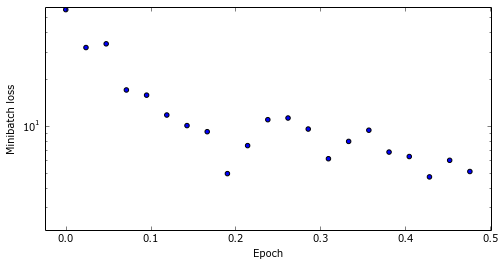

In [7]:
# Make  loss function against epoch plot
plt.figure(figsize=(8, 4))
plt.scatter(list(loss_epoch.keys()), list(loss_epoch.values()))
plt.yscale('log')
plt.ylabel('Minibatch loss')
plt.xlabel('Epoch')
plt.axis('tight')

# Save and display figure
plt.savefig('loss.png', bbox_inches='tight')
plt.show()